In [1]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 93.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Initial

In [ ]:
import os
import sys

# add the path of packages to system path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# add packages for computation
import numpy as np
import pandas as pd
#from arbitragerepair import constraints, repair

# add plot packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Read data

In [ ]:
df = pd.read_csv("sample.csv")

# extract mid prices and option specifications
T = df[df['quote']=='mid']['expiry'].values
K = df[df['quote']=='mid']['strike'].values
C = df[df['quote']=='mid']['call_fv'].values
F = df[df['quote']=='mid']['forward'].values
iv = df[df['quote']=='mid']['imp_vol'].values

# extract bid and ask prices
C_bid = df[df['quote']=='bid']['call_fv'].values
C_ask = df[df['quote']=='ask']['call_fv'].values

df.head()

,expiry,strike,quote,call_fv,imp_vol,forward
0,0.00274,411.593164,mid,10.748705,0.371924,421.954144
1,0.00274,413.327266,mid,9.279820,0.382008,421.954144
2,0.00274,416.314587,mid,6.889129,0.381486,421.954144
3,0.00274,418.629852,mid,5.334075,0.389442,421.954144
4,0.00274,421.861671,mid,3.570409,0.400000,421.954144


**Plot forward curve, call price surface and implied volatility surface**


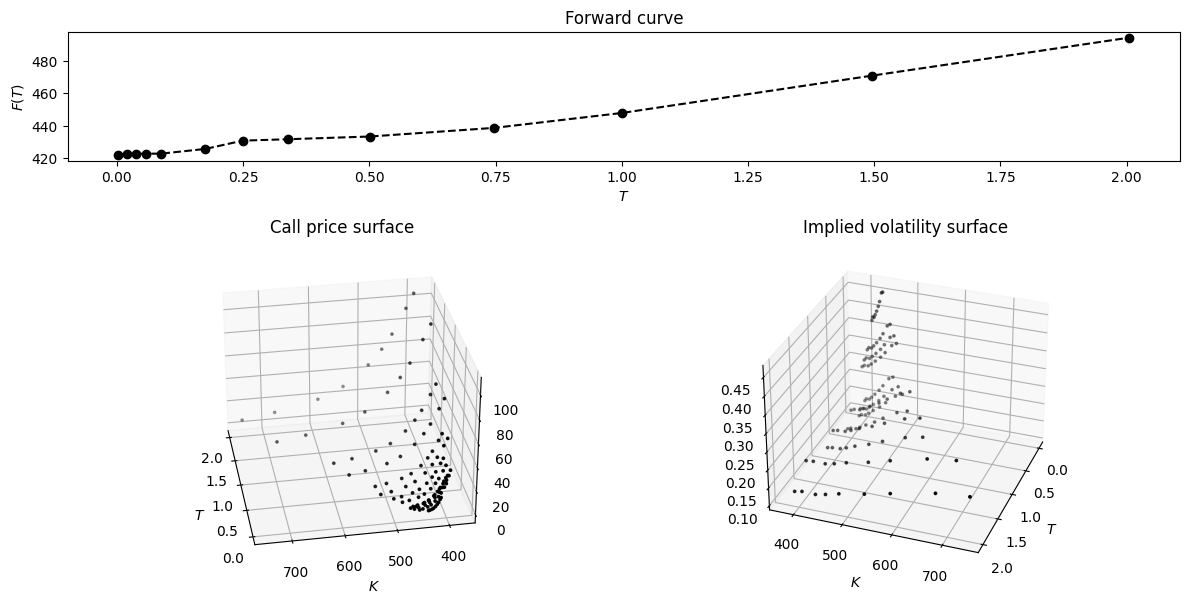

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

ax = fig.add_subplot(spec[0,:])  # plot the forward curve
ax.set_title('Forward curve')
unq_Ts, idx_T = np.unique(T, return_index=True)
ax.plot(unq_Ts, F[idx_T], '--ok')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$F(T)$')

ax = fig.add_subplot(spec[1:,0], projection='3d')
ax.set_title('Call price surface')
ax.scatter3D(T, K, C, s=3, color='k')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$K$')
ax.view_init(30,170)

ax = fig.add_subplot(spec[1:,1], projection='3d')
ax.set_title('Implied volatility surface')
ax.scatter3D(T, K, iv, s=3, color='k')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$K$')
ax.view_init(30,20)

plt.tight_layout()
plt.show()

**Normalise the data**

In [ ]:
# normalise strikes and prices
import constraints
normaliser = constraints.Normalise()
normaliser.fit(T, K, C, F)
T1, K1, C1 = normaliser.transform(T, K, C)

_, _, C1_bid = normaliser.transform(T, K, C_bid)
_, _, C1_ask = normaliser.transform(T, K, C_ask)

Detect Arbitrage

In [ ]:
# construct arbitrage constraints and detect violation
mat_A, vec_b, _, _ = constraints.detect(T1, K1, C1, verbose=True)

Number of violations to non-negative outright price:                   0/13
Number of violations to non-negative and unit-bounded vertical spread: 0/130
Number of violations to non-negative butterfly spread:                 0/104
Number of violations to non-negative calendar (horizontal) spread:     0/0
Number of violations to non-negative calendar vertical spread:         9/513
Number of violations to non-negative calendar butterfly spread:        126/3070


# **Repair**

L_1 Norm and L-ab Norm

In [ ]:
import repair

# repair arbitrage - l1-norm objective
epsilon1 = repair.l1(mat_A, vec_b, C1)


# repair arbitrage - l1ba objective
spread_ask = C1_ask - C1
spread_bid = C1 - C1_bid
spread = [spread_ask, spread_bid]

epsilon2 = repair.l1ba(mat_A, vec_b, C1, spread=spread)


In [ ]:
K01, C01 = normaliser.inverse_transform(K1, C1 + epsilon1)
K02, C02 = normaliser.inverse_transform(K1, C1 + epsilon2)

Compare the L1-norm repair and the L-BA repair

<ipython-input-22-20dd7c41eaa3>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
<ipython-input-22-20dd7c41eaa3>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


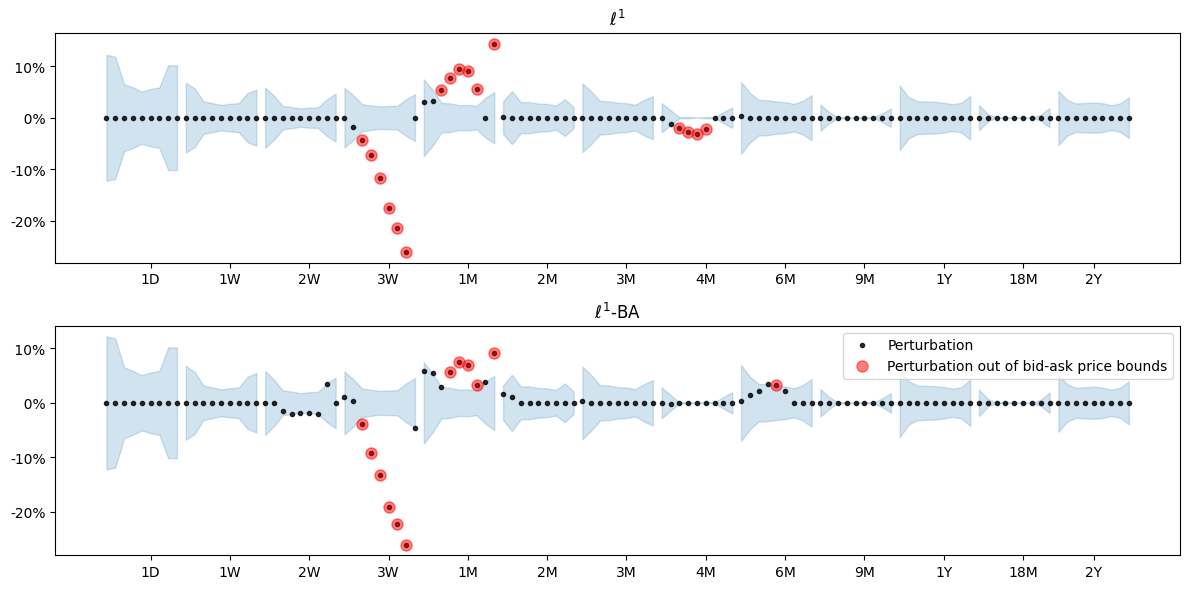

In [ ]:
tol = 1e-8
n_quote = len(C1)
unq_Ts, idx_T = np.unique(T1, return_index=True)

expiry_str = ['1D', '1W', '2W', '3W',
              '1M', '2M', '3M', '4M', '6M', '9M', '1Y', '18M', '2Y']

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(211)
ax.plot(epsilon1/C1, 'ko', markersize=3, alpha=.8)
mask1 = epsilon1[epsilon1>0] - spread_ask[epsilon1>0] > tol
ax.plot(np.arange(n_quote)[epsilon1>0][mask1],
        ((epsilon1/C1)[epsilon1>0])[mask1], 'ro', markersize=8, alpha=.5)
mask2 = epsilon1[epsilon1<0] + spread_bid[epsilon1<0] < -tol
ax.plot(np.arange(n_quote)[epsilon1<0][mask2],
        ((epsilon1/C1)[epsilon1<0])[mask2], 'ro', markersize=8, alpha=.5)
for t in unq_Ts:
    mask_t = T1==t
    ax.fill_between(np.arange(n_quote)[mask_t],
                    (-spread_bid/C1)[mask_t], (spread_ask/C1)[mask_t], color='C0', alpha=.2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_title(r"$\ell^1$")
ax.set_xticks(np.ceil((idx_T + np.hstack([idx_T[1:], len(T1)-1]))/2))
ax.set_xticklabels(expiry_str)

ax = fig.add_subplot(212)
ax.plot(epsilon2/C1, 'ko', markersize=3, alpha=.8, label='Perturbation')
mask1 = epsilon2[epsilon2>0] - spread_ask[epsilon2>0] > tol
ax.plot(np.arange(n_quote)[epsilon2>0][mask1],
        ((epsilon2/C1)[epsilon2>0])[mask1], 'ro', markersize=8, alpha=.5)
mask2 = epsilon2[epsilon2<0] + spread_bid[epsilon2<0] < -tol
ax.plot(np.arange(n_quote)[epsilon2<0][mask2],
        ((epsilon2/C1)[epsilon2<0])[mask2], 'ro', markersize=8, alpha=.5,
        label='Perturbation out of bid-ask price bounds')
for t in unq_Ts:
    mask_t = T1==t
    ax.fill_between(np.arange(n_quote)[mask_t],
                    (-spread_bid/C1)[mask_t], (spread_ask/C1)[mask_t], color='C0', alpha=.2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_title(r"$\ell^1$-BA")
ax.set_xticks(np.ceil((idx_T + np.hstack([idx_T[1:], len(T1)-1]))/2))
ax.set_xticklabels(expiry_str)
ax.legend()

plt.tight_layout()
plt.show()

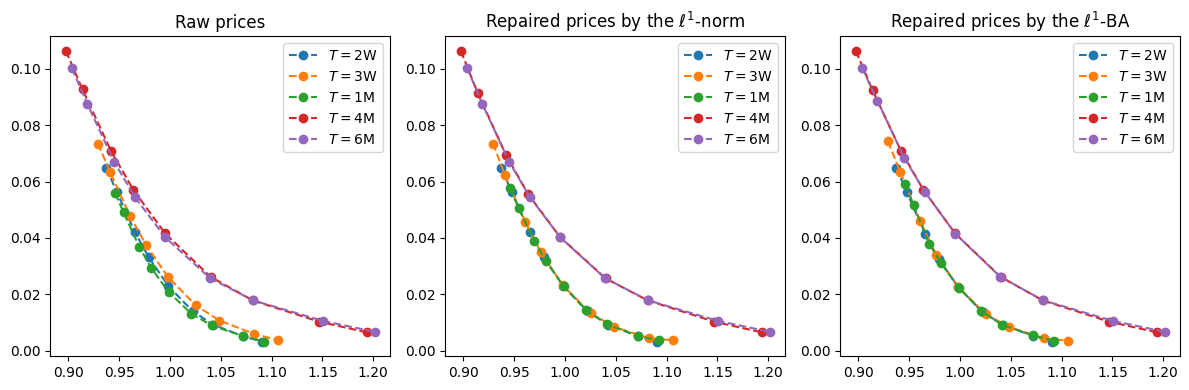

In [ ]:
idx_T_sub = [2,3,4,7,8]

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(131)
ax.set_title('Raw prices')
for i in idx_T_sub:
    mask_t = T1==unq_Ts[i]
    ax.plot(K1[mask_t], C1[mask_t], '--o', label=r'$T=$' + expiry_str[i])
ax.legend()

ax = fig.add_subplot(132)
ax.set_title(r'Repaired prices by the $\ell^1$-norm')
for i in idx_T_sub:
    mask_t = T1==unq_Ts[i]
    ax.plot(K1[mask_t], (C1+epsilon1)[mask_t], '--o', label=r'$T=$' + expiry_str[i])
ax.legend()

ax = fig.add_subplot(133)
ax.set_title(r'Repaired prices by the $\ell^1$-BA')
for i in idx_T_sub:
    mask_t = T1==unq_Ts[i]
    ax.plot(K1[mask_t], (C1+epsilon2)[mask_t], '--o', label=r'$T=$' + expiry_str[i])
ax.legend()

plt.tight_layout()
plt.show()